In [86]:
%matplotlib widget
# 3rd party
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lightkurve as lk

import tensorflow as tf

In [87]:
study_dir = Path(f"/Users/jochoa4/Desktop/studies/study_window_masks_05-27-2025/")
study_dir.mkdir(parents=True, exist_ok=True)

plot_dir = study_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

In [88]:
tce_tbl_fp = Path(
    "/Users/jochoa4/Projects/exoplanet_transit_classification/ephemeris_tables/preprocessing_tce_tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.loc[
        tce_tbl["label"].isin(["EB", "KP", "CP", "NTP", "NEB", "NPC"])
]
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition"})

/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_36446/1253199906.py:5: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)


### Show non-transit/transit model score vs example count by disposition

## Specific TCE Analysis

In [89]:
# dataset hyperparameters
n_durations_window = 5  # number of transit durations in each extracted window
detrend_n_durations_window = (
    1.5  # number of transit durations in each detrend window (primary/secondary)
)

frac_valid_cadences_in_window_thr = 0.85
frac_valid_cadences_it_thr = 0.85

maxmes_threshold = 7.1
buffer_time = (
    30  # in minutes, between in-transit cadences and out-of-transit cadences
)
n_durations_buffer = 1.5  # number of transit durations to use as a buffer for in transit mask points.
gap_width = 0.75
resampled_num_points = 100  # number of points in the window after resampling

rnd_seed = 42
size_img = [11, 11]  # resize images to this size
f_size = [
    3,
    3,
]  # enlarge `size_img` by these factors; final dimensions are f_size * size_img
center_target = False  # center target in images

In [ ]:
# TCE of interest
# tce_uid =  "178168644-1-S7"

# target = tce_uid.split('-')[0]
# sector_run = tce_uid.split('S')[-1]
target, sector_run = "198242678", "14-19""30034081", "7" # "309528896", "1-39" # "178168644", "7"

rng = np.random.default_rng(seed=42) #TODO: check if same seed

if plot_dir:
    plot_dir_target_sector_run = (
        plot_dir / f"target_{target}_sector_run_{sector_run}"
    )
    plot_dir_target_sector_run.mkdir(exist_ok=True, parents=True)
else:
    plot_dir_target_sector_run = None


t_sr_plot_dir = plot_dir / target / sector_run
t_sr_plot_dir.mkdir(parents=True, exist_ok=True)
# # t_sr_plot_dir = plot_dir / tce_uid
# # t_sr_plot_dir.mkdir(parents=True, exist_ok=True)

# # If plotting example info from tfrec
# tfrec_dir = Path("/Users/jochoa4/Desktop/datasets/TESS_exoplanet_dataset_05-04-2025_split_norm/tfrecords/train") # None
# tfrec_fp = tfrec_dir /   "norm_train_shard_2990-8611.tfrecord" #"norm_train_shard_2442-8611.tfrecord" # None

# lc_dir = Path("/Users/jochoa4/Downloads/")

In [190]:
def _load_target_sector_run_data(df, target, sector_run):
    return df[(df["target_id"] == int(target)) & (df["sector_run"] == str(sector_run))].copy()

sector_run_data = _load_target_sector_run_data(tce_tbl, target, sector_run)

In [191]:
sector_run_data.head()

,taskFileId,targetIndexNumber,target_id,numberOfPlanets,tce_plnt_num,numberOfAlerts,tce_max_sngle_ev,tce_max_mult_ev,planetCandidate.maxSesInMes,planetCandidate.suspectedEclipsingBinary,...,label_astronet-qlp,matched_villanova_ebs,match_corr_coef_villanova_ebs,tec_fluxtriage_pass,tec_fluxtriage_comment,matched_object,tce_dikco_msky_original,tce_dikco_msky_err_original,tce_dicco_msky_original,tce_dicco_msky_err_original
1239,22283.0,1.0,198242678,3.0,1,4.0,371.302094,156.994492,141.999481,0.0,...,NaN,198242678-1,0.935027,NaN,NaN,198242678-1,0.689127,2.536326,1.674038,2.500926


In [192]:
sector_run_arr = []

if "-" in sector_run:
    start_sector, end_sector = [
        int(sector) for sector in sector_run.split("-")
    ]
    sector_run_arr = [
        sector for sector in range(start_sector, end_sector + 1)
    ]
else:
    sector_run_arr = [int(sector_run)]

# find light curve data for target, sector_run pair


search_lc_res = lk.search_lightcurve(
    target=f"tic{target}",
    mission="TESS",
    author=("TESS-SPOC", "SPOC"),
    exptime=120,
    cadence="long",
    sector=sector_run_arr,
)

lcfs = search_lc_res.download_all(
    download_dir=str(lc_dir), quality_bitmask="default", flux_column="pdcsap_flux"
)

found_sectors = [int(el.split(' ')[-1]) for el in search_lc_res.table["mission"]]
assert len(found_sectors) != 0

print(f"Found {len(found_sectors)} sectors with light curve data for target, sector_run: {target}, {sector_run}.")


Found 5 sectors with light curve data for target, sector_run: 198242678, 14-19.


In [193]:
target_sector_run_tce_data = []

for (
    tce_i,
    tce_data,
) in sector_run_data.iterrows():  # get all tces in target, sector_run pair
    target_sector_run_tce_data.append(
        {
            "tce_time0bk": tce_data["tce_time0bk"],
            "tce_period": tce_data["tce_period"],
            "tce_duration": tce_data["tce_duration"],
            "tce_maxmes": tce_data["tce_maxmes"],
            "tce_maxmesd": tce_data["tce_maxmesd"],
        }
    )

In [194]:

def find_first_epoch_after_this_time(epoch, period, reference_time):
    if epoch < reference_time:
        tepoch = epoch + period * np.ceil((reference_time - epoch) / period)
    else:
        tepoch = epoch - period * np.floor((epoch - reference_time) / period)

    return tepoch

def old_build_transit_mask_for_lightcurve(
    time,
    tce_list,
    buffer_time,
    n_durations_buffer: float = 0,
    n_durations_window: int = 5,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)
    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        buffer_time /= 1440  # convert minutes to days
        duration /= 24  # convert hours to days

        in_transit_mask |= np.abs((time - epoch) % period) < (
            duration * (n_durations_buffer + n_durations_window / 2) + buffer_time #(n_durations_buffer + n_durations_window / 2) + buffer_time
        )  # transit mask buffer corresponds to points that cannot be within a oot flux window of n_durations size

    return in_transit_mask


def old_build_secondary_transit_mask_for_lightcurve(
    time,
    tce_list,
    buffer_time: float = 0,
    n_durations_buffer: float = 0,
    n_durations_window: int = 5,
    maxmes_threshold: float = 7.1,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)

    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        maxmes = tce["tce_maxmes"]
        maxmesd = tce["tce_maxmesd"]

        duration /= 24  # convert hours to days
        if maxmes > maxmes_threshold:
            secondary_epoch = epoch + maxmesd
            in_transit_mask |= np.abs((time - secondary_epoch) % period) < (
                duration * (n_durations_window / 2) + buffer_time
            )  # transit mask buffer corresponds to points that cannot be within a oot flux window of n_durations size

    return in_transit_mask


def find_first_epoch_after_this_time(epoch, period, reference_time):
    if epoch < reference_time:
        tepoch = epoch + period * np.ceil((reference_time - epoch) / period)
    else:
        tepoch = epoch - period * np.floor((epoch - reference_time) / period)

    return tepoch

def new_v1_build_transit_mask_for_lightcurve(
    time,
    tce_list,
    buffer_time,
    n_durations_buffer: float = 0,
    n_durations_window: int = 5,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)
    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        buffer_time /= 1440  # convert minutes to days
        print(f"duration: {duration}")
        duration /= 24  # convert hours to days
        print(f"duration_days: {duration}")

        first_transit_time = find_first_epoch_after_this_time(
        epoch, period, time[0]
        )
        
        midtransit_points_arr = np.array(
        [
            first_transit_time + phase_k * period
            for phase_k in range(int(np.ceil((time[-1] - time[0]) / period)))
        ]
        )

        start_time_windows, end_time_windows = (
        midtransit_points_arr - n_durations_window * duration / 2,
        midtransit_points_arr + n_durations_window * duration / 2,
        )

        for t0 in midtransit_points_arr:
            in_transit_mask |= np.abs(time - t0) < n_durations_window * duration / 2
    
        # phase = ((time - epoch + 0.5 * period) % period - 0.5 * period)
        # in_transit_mask |= np.abs(phase) < (n_durations_window * duration / (2 * n_durations_window))

        # in_transit_mask |= np.abs((time - epoch) % period) =< (
        #     duration * (n_durations_window / 2) + buffer_time #(n_durations_buffer + n_durations_window / 2) + buffer_time
        # )  # transit mask buffer corresponds to points that cannot be within a oot flux window of n_durations size
    
    return in_transit_mask


def new_v1_build_secondary_transit_mask_for_lightcurve(
    time,
    tce_list,
    buffer_time: float = 0,
    n_durations_buffer: float = 0,
    n_durations_window: int = 5,
    maxmes_threshold: float = 7.1,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)

    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        maxmes = tce["tce_maxmes"]
        maxmesd = tce["tce_maxmesd"]

        duration /= 24  # convert hours to days
        if maxmes > maxmes_threshold:
            secondary_epoch = epoch + maxmesd
            in_transit_mask |= np.abs((time - secondary_epoch) % period) < (
                duration * (n_durations_buffer + n_durations_window / 2) + buffer_time
            )  # transit mask buffer corresponds to points that cannot be within a oot flux window of n_durations size

    return in_transit_mask

def new_v2_build_transit_mask_for_lightcurve(
    time,
    tce_list,
    buffer_time,
    n_durations_buffer: float = 0,
    n_durations_window: int = 5,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)
    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        duration /= 24  # convert hours to days
        
        #distance to nearest transit center (days)
        transit_proximity_days = ((time - epoch + 0.5 * period) % period - 0.5 * period)
        in_transit_mask |= np.abs(transit_proximity_days) <= (
            ((n_durations_window * duration) / 2)
        )
    
    return in_transit_mask


def new_v2_build_secondary_transit_mask_for_lightcurve(
    time,
    tce_list,
    buffer_time: float = 0,
    n_durations_buffer: float = 0,
    n_durations_window: int = 5,
    maxmes_threshold: float = 7.1,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)

    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        maxmes = tce["tce_maxmes"]
        maxmesd = tce["tce_maxmesd"]

        duration /= 24  # convert hours to days
        if maxmes > maxmes_threshold:
            secondary_epoch = epoch + maxmesd
            transit_proximity_days = ((time - secondary_epoch + 0.5 * period) % period - 0.5 * period)
        
            in_transit_mask |= np.abs(transit_proximity_days) <= (
            ((n_durations_window * duration) / 2)
        )# transit mask buffer corresponds to points that cannot be within a oot flux window of n_durations size

    return in_transit_mask

### Distance to Nearest Transit Calculation w/ example time arr

In [195]:
target_sector_run_tce_data

[{'tce_time0bk': 1687.6912795530343,
  'tce_period': 4.630879134159551,
  'tce_duration': 5.098381254778151,
  'tce_maxmes': 8.547236442565918,
  'tce_maxmesd': 2.2101738452911377}]

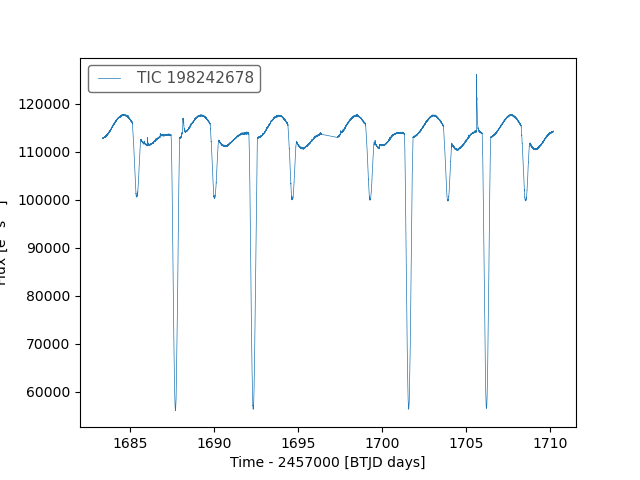

target_sector_run_tce_data: [{'tce_time0bk': 1687.6912795530343, 'tce_period': 4.630879134159551, 'tce_duration': 5.098381254778151, 'tce_maxmes': 8.547236442565918, 'tce_maxmesd': 2.2101738452911377}]


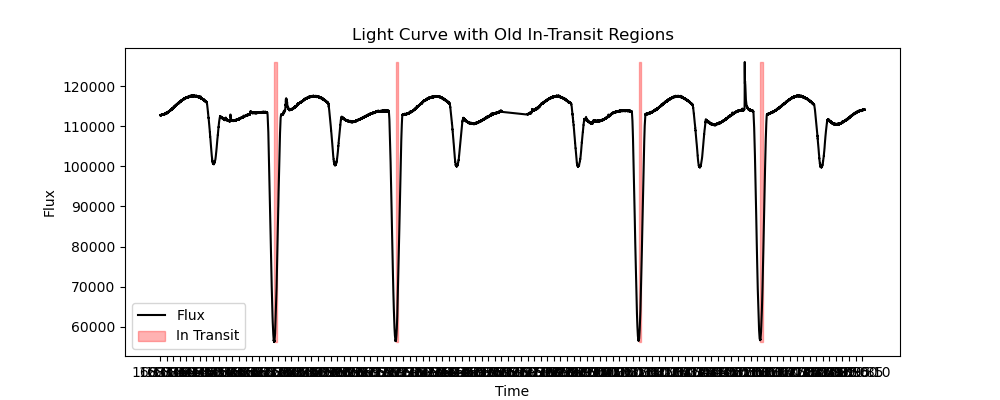

duration: 5.098381254778151
duration_days: 0.21243255228242297
sum_v1: 591


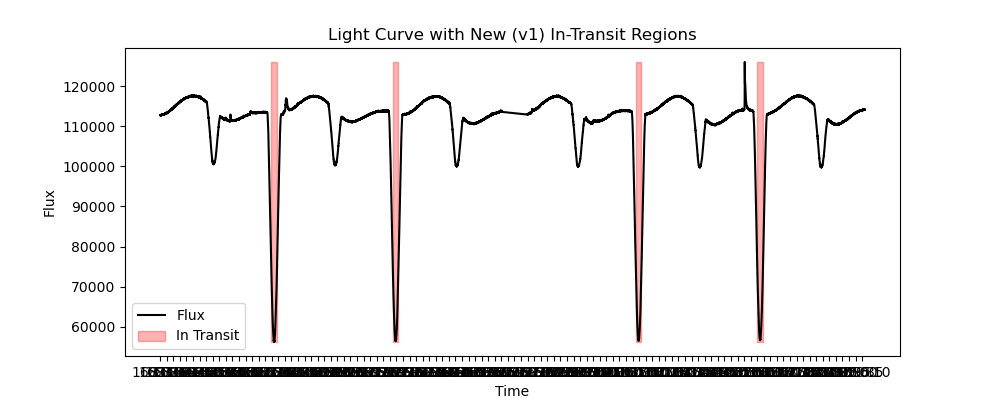

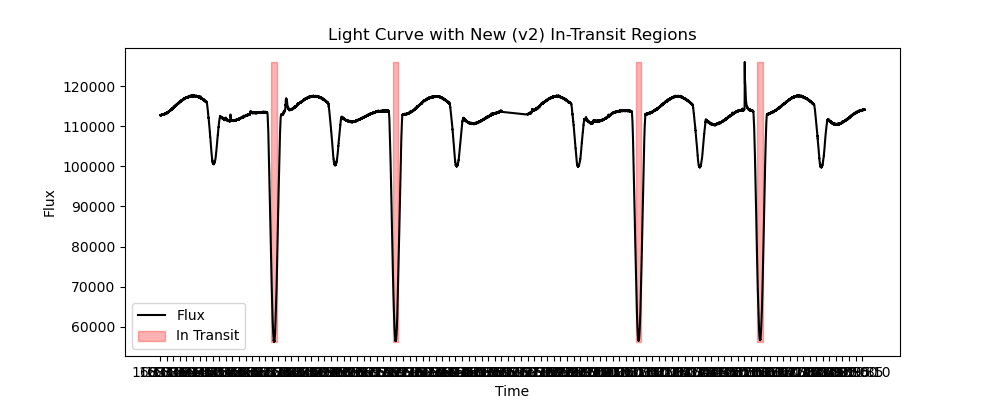

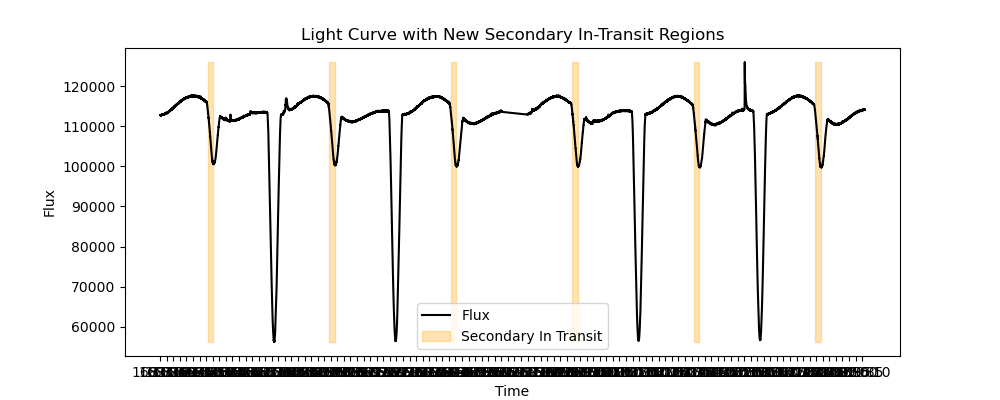

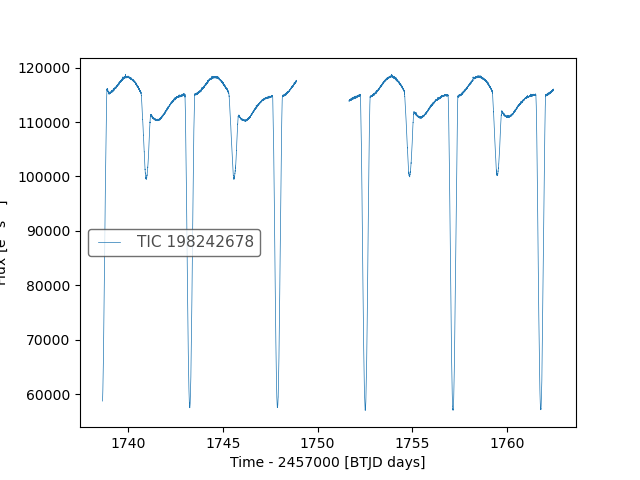

target_sector_run_tce_data: [{'tce_time0bk': 1687.6912795530343, 'tce_period': 4.630879134159551, 'tce_duration': 5.098381254778151, 'tce_maxmes': 8.547236442565918, 'tce_maxmesd': 2.2101738452911377}]


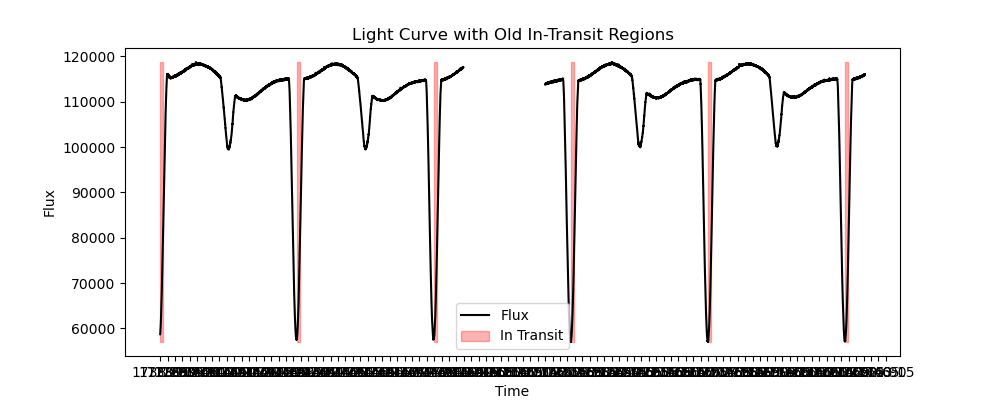

duration: 5.098381254778151
duration_days: 0.21243255228242297
sum_v1: 760


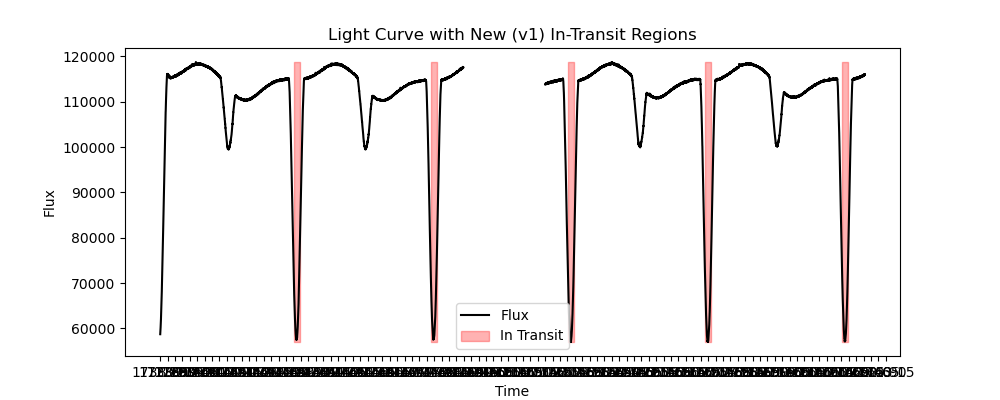

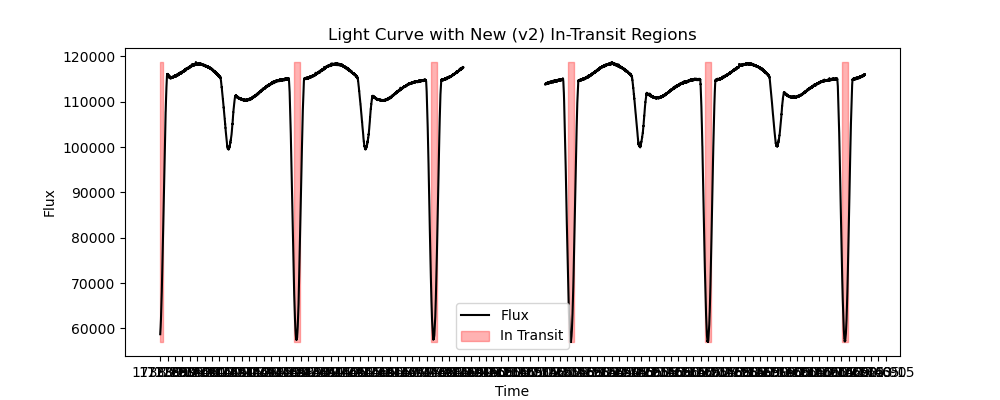

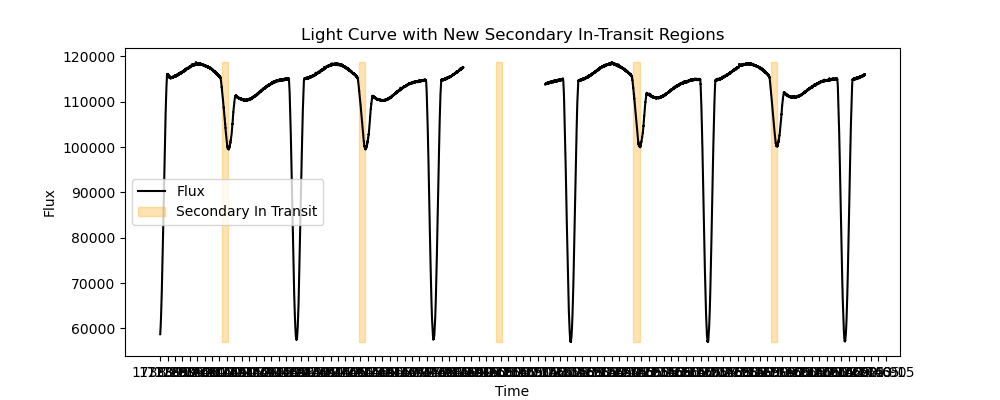

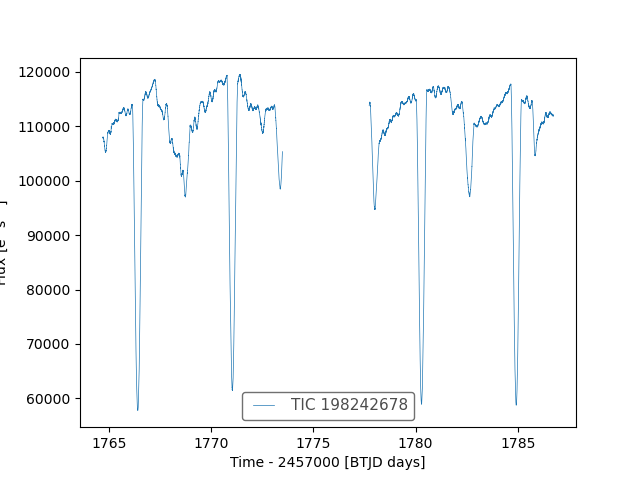

target_sector_run_tce_data: [{'tce_time0bk': 1687.6912795530343, 'tce_period': 4.630879134159551, 'tce_duration': 5.098381254778151, 'tce_maxmes': 8.547236442565918, 'tce_maxmesd': 2.2101738452911377}]


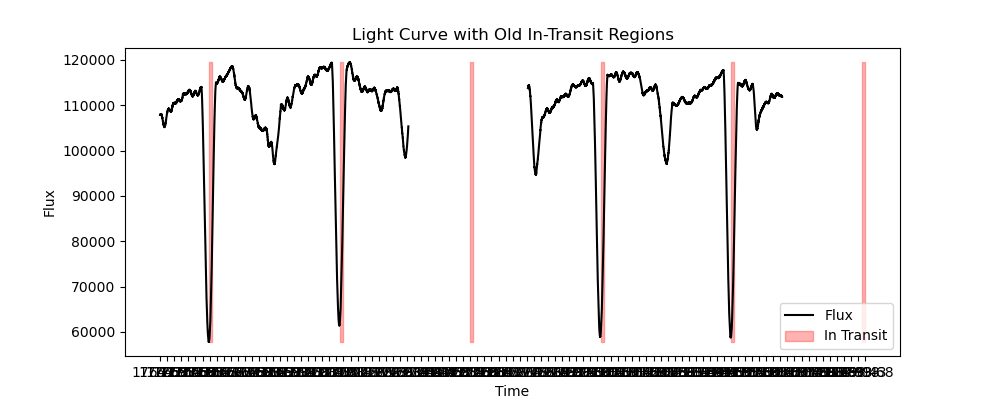

duration: 5.098381254778151
duration_days: 0.21243255228242297
sum_v1: 903


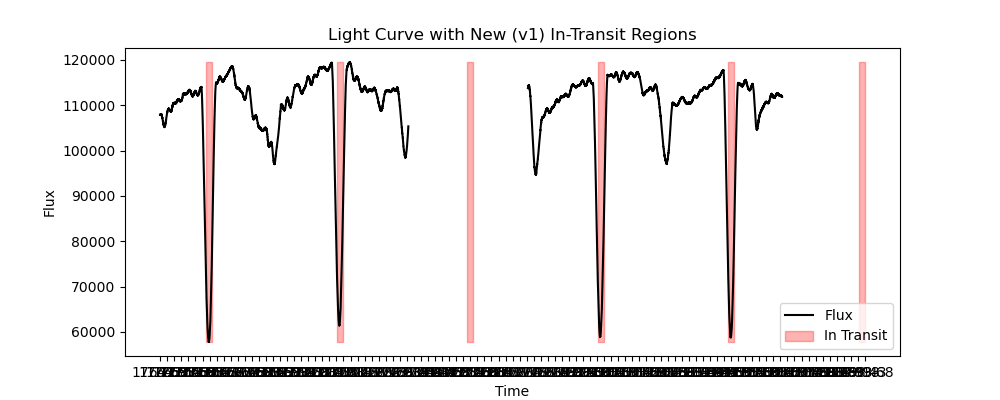

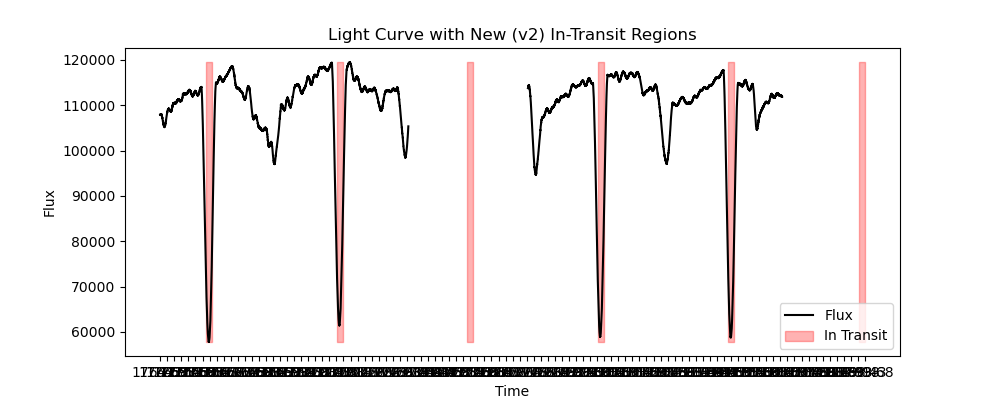

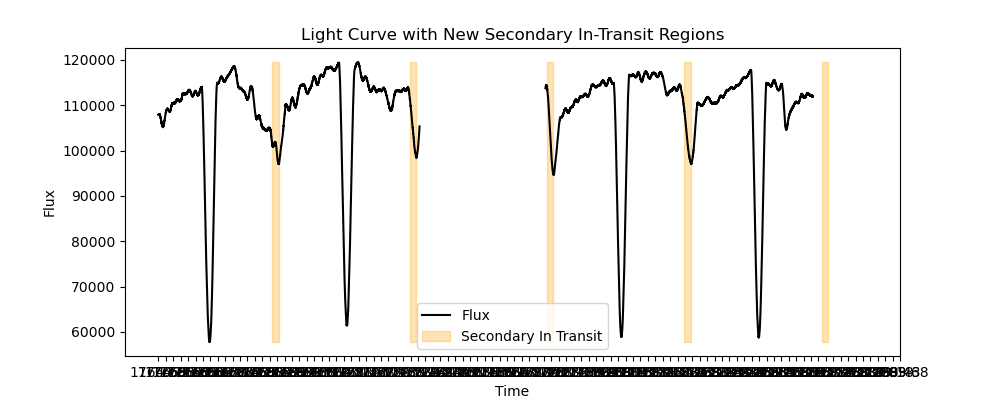

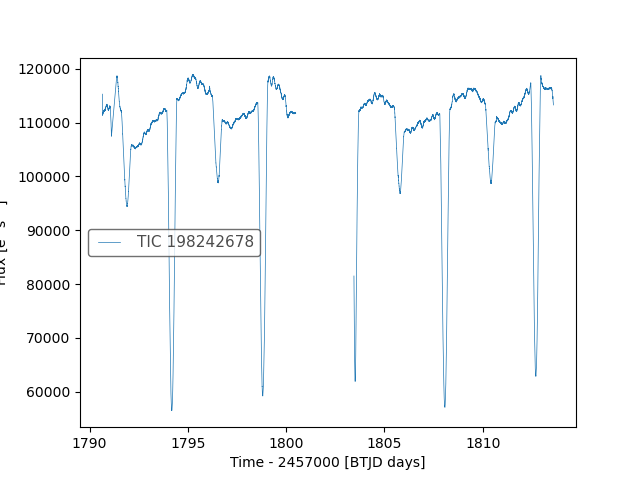

target_sector_run_tce_data: [{'tce_time0bk': 1687.6912795530343, 'tce_period': 4.630879134159551, 'tce_duration': 5.098381254778151, 'tce_maxmes': 8.547236442565918, 'tce_maxmesd': 2.2101738452911377}]


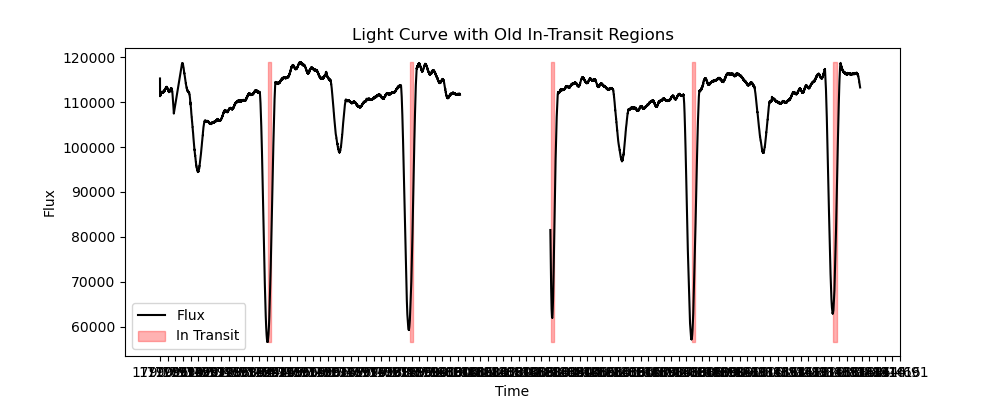

duration: 5.098381254778151
duration_days: 0.21243255228242297
sum_v1: 694


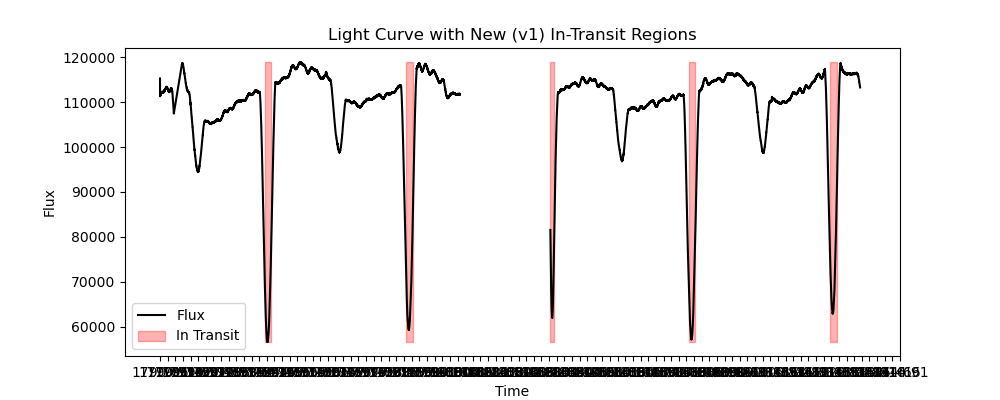

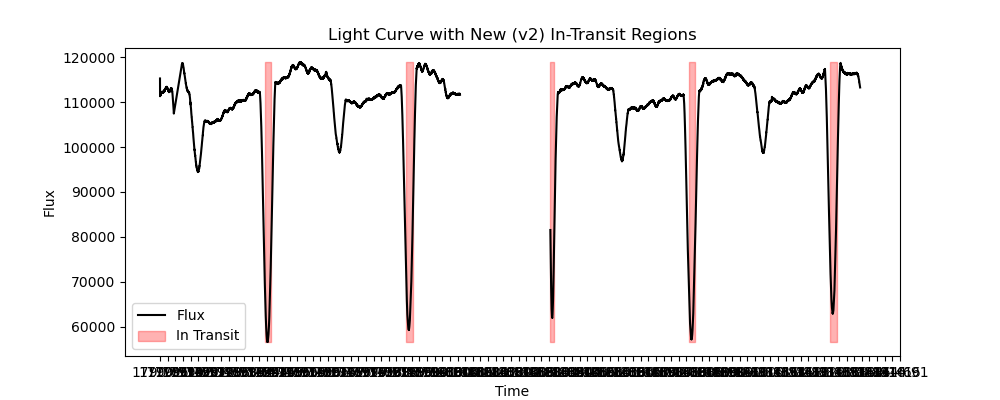

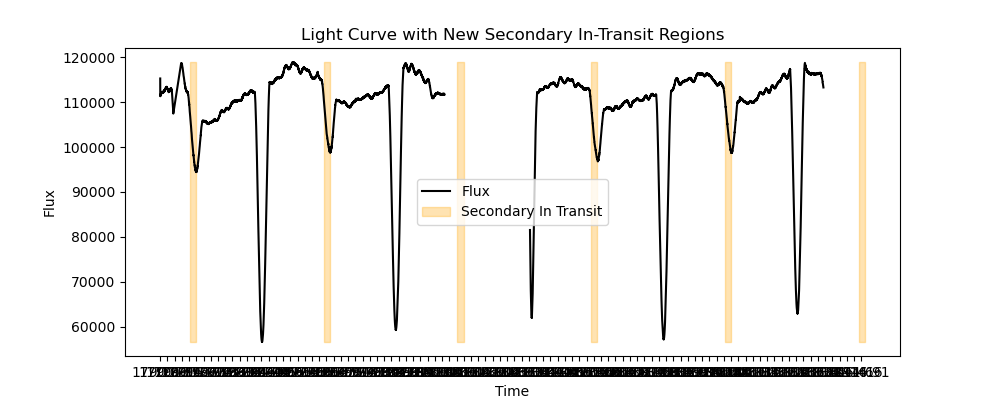

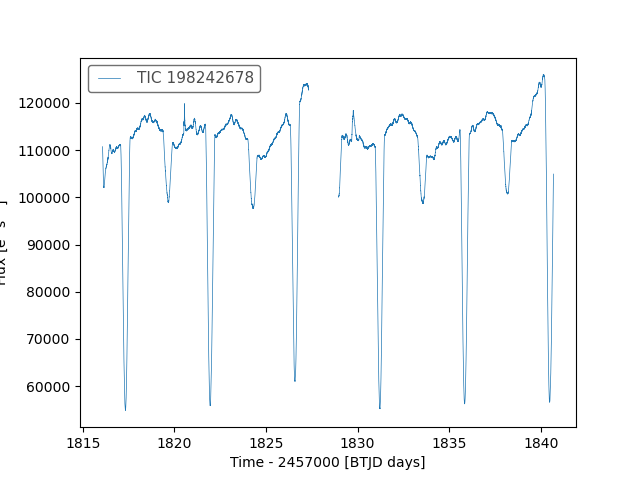

target_sector_run_tce_data: [{'tce_time0bk': 1687.6912795530343, 'tce_period': 4.630879134159551, 'tce_duration': 5.098381254778151, 'tce_maxmes': 8.547236442565918, 'tce_maxmesd': 2.2101738452911377}]


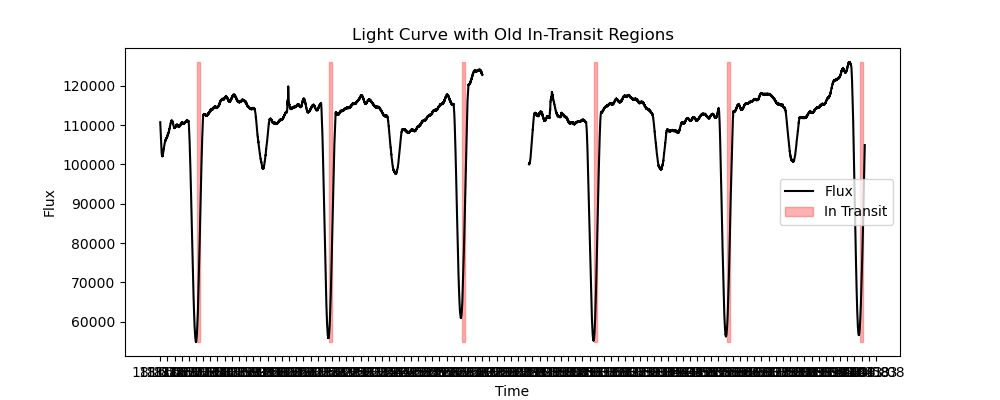

duration: 5.098381254778151
duration_days: 0.21243255228242297
sum_v1: 887


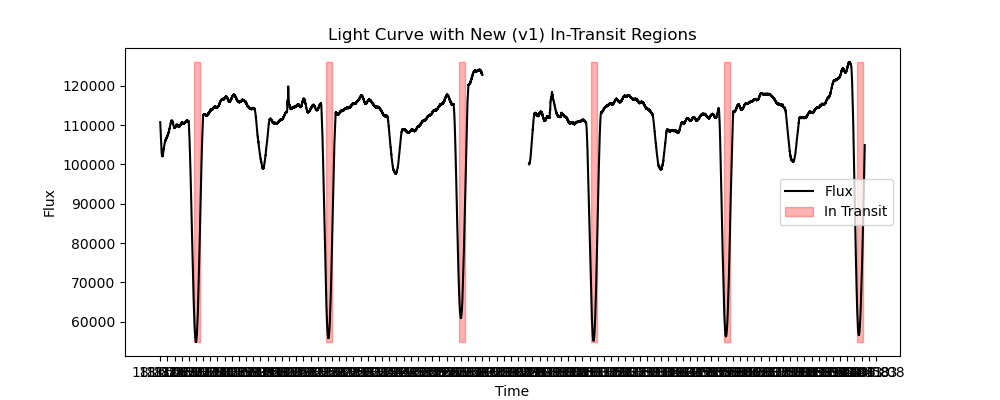

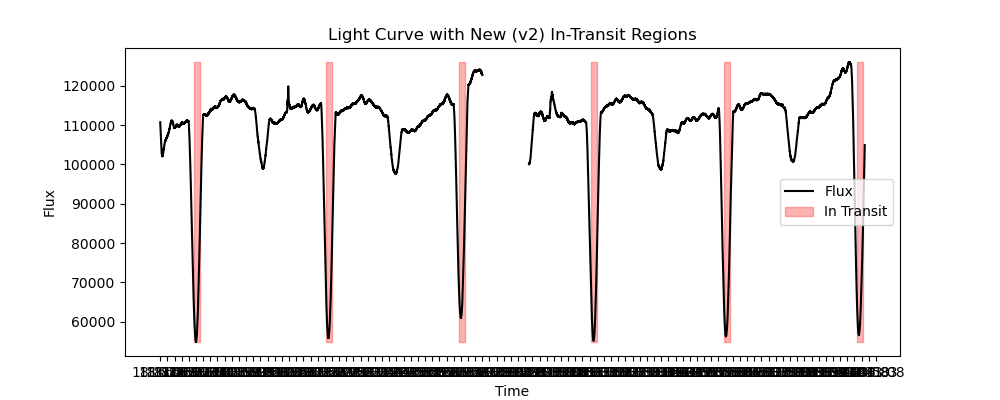

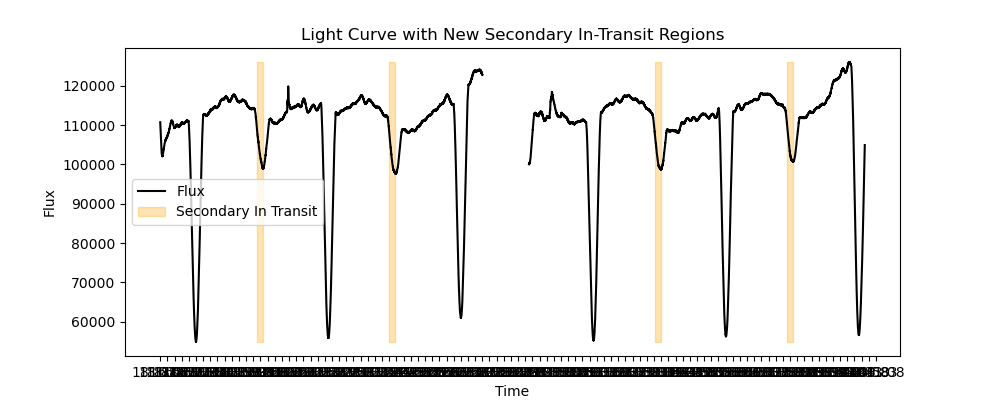

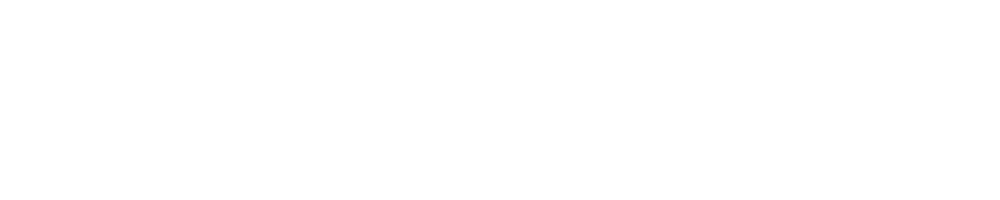

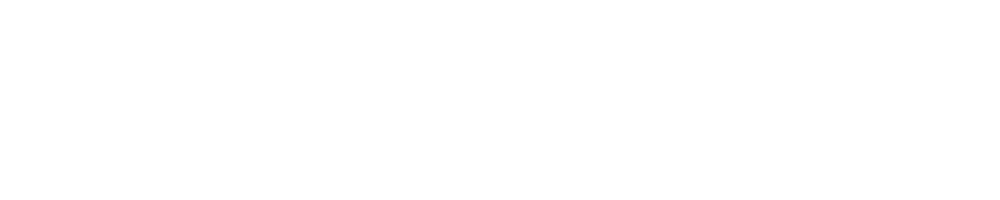

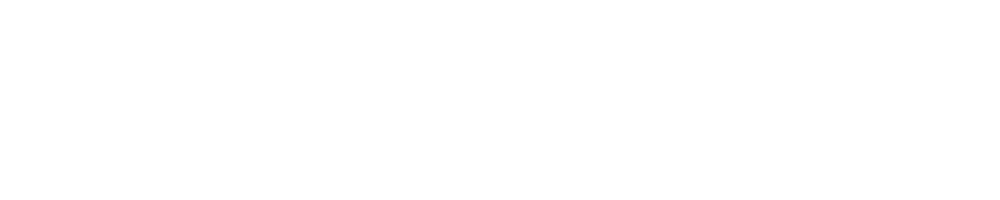

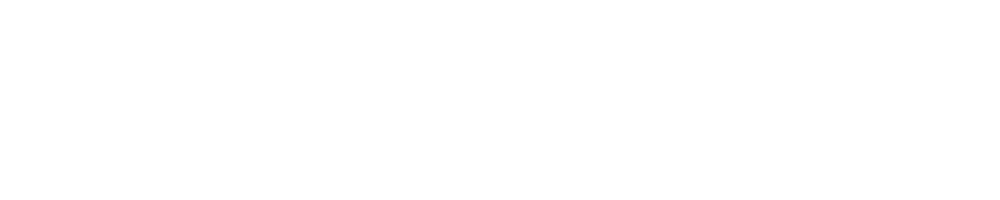

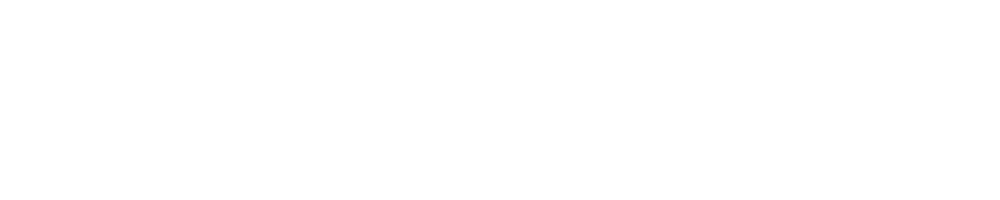

In [196]:

# for given sector in sector_run
for sector, lcf in zip(found_sectors, lcfs):

    in_transit_mask = []
    secondary_in_transit_mask = []

    data_for_tce_sector = {
        "sector": sector,
        "transit_examples": {
            "flux": [],
            "t": [],
            "it_img": [],
            "oot_img": [],
            "diff_img": [],
            "snr_img": [],
            "target_img": [],
            "target_pos": [],
        },
        "not_transit_examples": {
            "flux": [],
            "t": [],
            "it_img": [],
            "oot_img": [],
            "diff_img": [],
            "snr_img": [],
            "target_img": [],
            "target_pos": [],
        },
    }
    if plot_dir_target_sector_run:
        plot_dir_target_sector_run_sector = (
            plot_dir_target_sector_run / f"sector_{sector}"
        )
        plot_dir_target_sector_run_sector.mkdir(exist_ok=True, parents=True)
    else:
        plot_dir_target_sector_run_sector = None

    # lcf = lk.LightCurve(
    #     {"time": lcf.time.value, "flux": np.array(lcf.flux.value)}
    # )  # np array accounts for masked flux

    plt.figure(figsize=(10,2))

    f, ax = plt.subplots()
    lcf.plot(ax=ax)
    # ax.set_xlim([t_start, t_end])
    # ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | True Label {win_label}")
    # f.savefig(ex_plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")
    plt.show()
    # lcf.plot()

    raw_time, raw_flux = lcf.time.value, lcf.flux.value

    #TODO: remove
    n_durations_window = 1
    n_durations_buffer = 0
    buffer_time = 0

    print(f"target_sector_run_tce_data: {target_sector_run_tce_data}")
    # Build masks
    # Mask for all points that can possibly be included in an in transit flux window + buffer
    old_in_transit_mask = old_build_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        buffer_time=buffer_time,
        n_durations_buffer=n_durations_buffer,
        n_durations_window=n_durations_window,
    )

    # Mask for weak secondary transits
    old_secondary_in_transit_mask = old_build_secondary_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        buffer_time=buffer_time,
        n_durations_buffer=n_durations_buffer,
        n_durations_window=n_durations_window,
        maxmes_threshold=maxmes_threshold,
    )
    plt.figure(figsize=(10,4))
    plt.plot(raw_time, raw_flux, label='Flux', color='black')
    
    #overlay it regions as shaded bands
    plt.fill_between(raw_time, raw_flux.min(), raw_flux.max(),
                     where=old_in_transit_mask,
                     color='red', alpha=0.3,
                     label="In Transit")
    
    plt.xticks(np.arange(raw_time.min(), raw_time.max(), 0.25))
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.title("Light Curve with Old In-Transit Regions")
    plt.legend()
    plt.savefig(t_sr_plot_dir / f"old_1td_windows_masked_t_{target}_sr_{sector_run}_s_{sector}.png")
    plt.show()
    # plt.close()

       # Mask for all points that can possibly be included in an in transit flux window + buffer
    new_v1_in_transit_mask = new_v1_build_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        buffer_time=buffer_time,
        n_durations_buffer=n_durations_buffer,
        n_durations_window=n_durations_window,
    )

    # Mask for weak secondary transits
    new_v1_secondary_in_transit_mask = new_v1_build_secondary_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        buffer_time=buffer_time,
        n_durations_buffer=n_durations_buffer,
        n_durations_window=n_durations_window,
        maxmes_threshold=maxmes_threshold,
    )
    print(f"sum_v1: {new_v1_in_transit_mask.sum()}")

    plt.figure(figsize=(10,4))
    plt.plot(raw_time, raw_flux, label='Flux', color='black')
    
    #overlay it regions as shaded bands
    plt.fill_between(raw_time, raw_flux.min(), raw_flux.max(),
                     where=new_v1_in_transit_mask,
                     color='red', alpha=0.3,
                     label="In Transit")
    
    plt.xticks(np.arange(raw_time.min(), raw_time.max(), 0.25))
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.title("Light Curve with New (v1) In-Transit Regions")
    plt.legend()
    plt.savefig(t_sr_plot_dir / f"new_v1_1td_windows_t_{target}_sr_{sector_run}_s_{sector}.png")
    plt.show()

    new_v2_in_transit_mask = new_v2_build_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        buffer_time=buffer_time,
        n_durations_buffer=n_durations_buffer,
        n_durations_window=n_durations_window,
    )

    # Mask for weak secondary transits
    new_v2_secondary_in_transit_mask = new_v2_build_secondary_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        buffer_time=buffer_time,
        n_durations_buffer=n_durations_buffer,
        n_durations_window=n_durations_window,
        maxmes_threshold=maxmes_threshold,
    )

    plt.figure(figsize=(10,4))
    plt.plot(raw_time, raw_flux, label='Flux', color='black')
    
    #overlay it regions as shaded bands
    plt.fill_between(raw_time, raw_flux.min(), raw_flux.max(),
                     where=(new_v2_in_transit_mask),
                     color='red', alpha=0.3,
                     label="In Transit")
    
    plt.xticks(np.arange(raw_time.min(), raw_time.max(), 0.25))
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.title("Light Curve with New (v2) In-Transit Regions")
    plt.legend()
    plt.savefig(t_sr_plot_dir / f"new_v2_1td_windows_masked_t_{target}_sr_{sector_run}_s_{sector}.png")
    plt.show()
    # plt.close()
    

    plt.figure(figsize=(10,4))
    plt.plot(raw_time, raw_flux, label='Flux', color='black')
    
    #overlay it regions as shaded bands
    plt.fill_between(raw_time, raw_flux.min(), raw_flux.max(),
                     where=new_v2_secondary_in_transit_mask,
                     color='orange', alpha=0.3,
                     label="Secondary In Transit")
    
    plt.xticks(np.arange(raw_time.min(), raw_time.max(), 0.25))
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.title("Light Curve with New Secondary In-Transit Regions")
    plt.legend()
    plt.savefig(t_sr_plot_dir / f"new_v2_1td_windows_masked_t_{target}_sr_{sector_run}_s_{sector}.png")
    plt.show()

    # plt.figure(figsize=(10,2))
    # plt.plot(raw_time[in_transit_mask], [1] *in_transit_mask.sum(), 'r|', markersize=10)
    # plt.yticks([])
    # plt.title("Primary In-transit cadences")
    # plt.xlabel("time")
    # plt.show()
    # plt.close()

    # plt.figure(figsize=(10,2))
    # plt.plot(raw_time[secondary_in_transit_mask], [1] *secondary_in_transit_mask.sum(), 'r|', markersize=10)
    # plt.yticks([])
    # plt.title("Secondary In-transit cadences")
    # plt.xlabel("time")
    # plt.show()
    # plt.close()

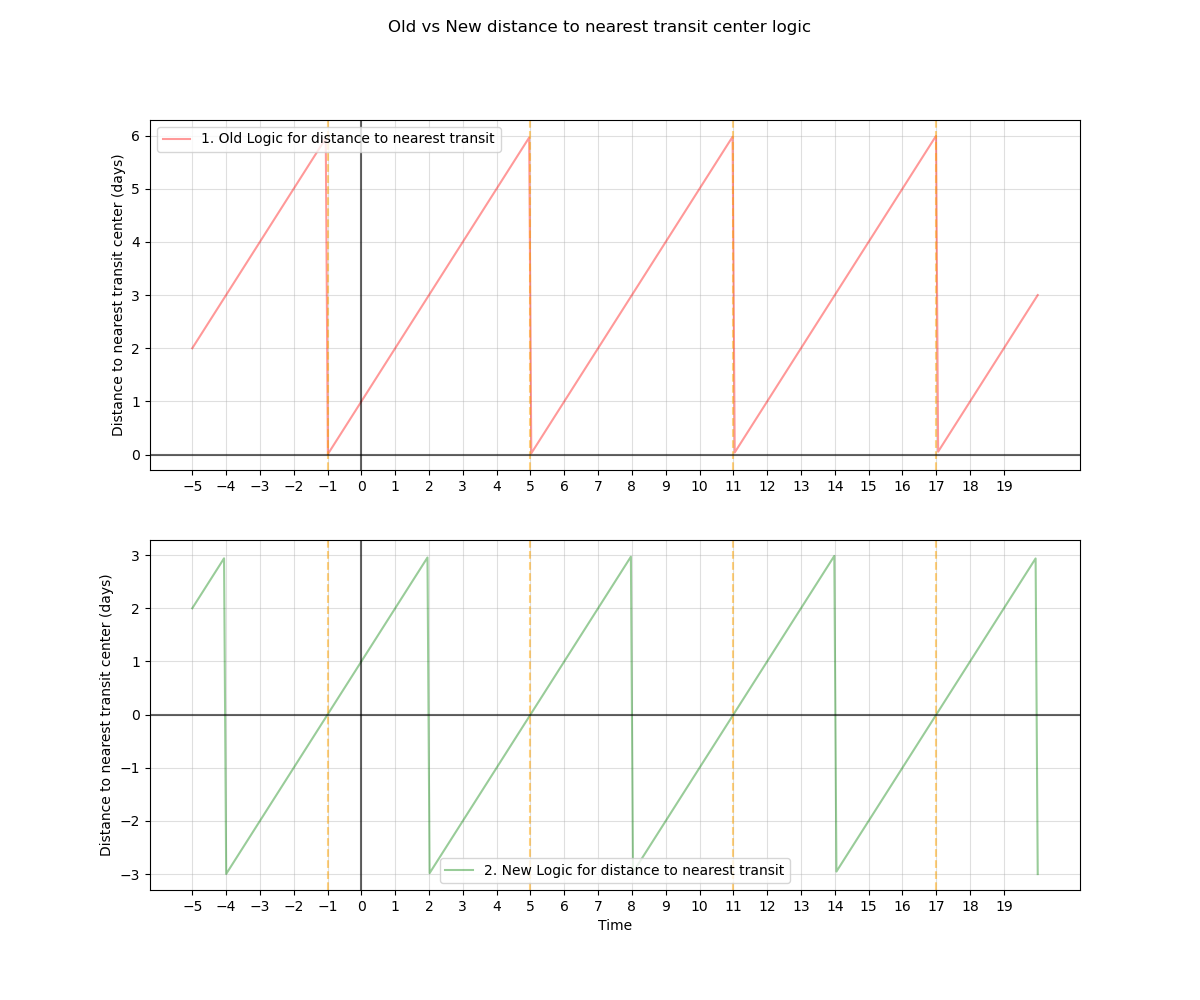

In [197]:
time = np.linspace(-5, 20, 400)

epoch = 5
period = 6
duration = 2

old = (time - epoch) % period
new = (((time - epoch) - 0.5 * period) % period) - 0.5 * period

transit_centers = np.arange(epoch - 2 * period, stop=time[-1] + 0.0001, step=period)

fig, axes = plt.subplots(2, 1, figsize=(12,10))

data = [old, new]
titles = [
    "1. Old Logic for distance to nearest transit",
    "2. New Logic for distance to nearest transit"
]
colors = ["red", "green"]

for i, ax in enumerate(axes):
    ax.plot(time, data[i], color=colors[i], label=titles[i], alpha=0.4)
    for t in transit_centers:
        if t >= time[0] and t <= time[-1]:
            ax.axvline(t, color="orange", linestyle ='--', alpha=0.5)
    ax.axvline(0, color="black", linestyle ='-', alpha=0.6)
    ax.axhline(0, color="black", linestyle ='-', alpha=0.6)
    ax.set_xticks(np.arange(time[0], time[-1]))
    ax.legend()
    ax.grid(True, alpha=0.4)
    ax.set_ylabel("Distance to nearest transit center (days)")
    
ax.set_xlabel("Time")
plt.suptitle("Old vs New distance to nearest transit center logic")
plt.show()
plt.savefig(plot_dir / f"transit_proximity_new_vs_old.png")




This now allows for proper filtering by cadence for nearby timestamps

# Choosing interesting TCE examples

In [198]:
scores_tbls_dir = Path(
    "/Users/jochoa4/Desktop/pfe_transfers/predict_model_05-04-2025_v2_e19/"
)

scores_tbl_fp = scores_tbls_dir / "preds_train.csv"

tce_tbl_fp = Path(
    "/Users/jochoa4/Projects/exoplanet_transit_classification/ephemeris_tables/preprocessing_tce_tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.loc[
        tce_tbl["label"].isin(["EB", "KP", "CP", "NTP", "NEB", "NPC"])
]
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition"})

train_tbl = pd.read_csv(scores_tbls_dir / "preds_train.csv")

def _get_tce_uid_from_examples(x):
    tce_uid = x["uid"].split("_")[0]
    return tce_uid

def _get_target_id_from_examples(x):
    target_id = x["uid"].split("-")[0]
    return target_id

train_tbl["tce_uid"] = train_tbl.apply(_get_tce_uid_from_examples, axis=1)
train_tbl["target_id"] = train_tbl.apply(_get_target_id_from_examples, axis=1)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_max_mult_ev"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_time0bk"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_period"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)


train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_max_mult_ev"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_maxmes"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_maxmesd"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_time0bk"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "sector_run"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_36446/3519704398.py:11: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)


Examples from Target Sectors with TCEs w/ tce_maxmes > 7.1 and tce_maxmes < 7.1

In [199]:
groups = tce_tbl.groupby(["target_id", "sector_run"])

In [219]:
prim_and_sec_exs = groups.filter(lambda g: (g["disposition"].isin(["EB", "CP", "KP"]).sum() > 1) and ((g["tce_maxmes"] > 7.1).any()) and ((g["tce_maxmes"] < 7.1).any()))


In [220]:
sec_exs = groups.filter(lambda g: (g["disposition"].isin(["EB", "CP", "KP"]).sum() > 1) and ((g["tce_maxmes"] > 7.1).any()))[["target_id", "sector_run", "tce_maxmes"]]


In [221]:
prim_and_sec_groups = prim_and_sec_exs.groupby(["target_id", "sector_run"])

In [222]:
sec_groups = sec_exs.groupby(["target_id", "sector_run"])

In [223]:
prim_and_sec_groups.size().sort_values()

target_id  sector_run
11437325   18            2
237277760  22            2
           50            2
           53            2
404103665  14-19         2
                        ..
269701147  14-23         3
316207527  12            3
260647166  1-13          4
142276270  14-23         4
309528896  1-39          4
Length: 66, dtype: int64

In [224]:
sec_groups.size().sort_values()

target_id  sector_run
11437325   18            2
308184924  11            2
           1-65          2
297899564  14-60         2
289722957  25            2
                        ..
259377017  3             3
269701147  14-41         3
309528896  1-39          4
142276270  14-23         4
260647166  1-13          4
Length: 145, dtype: int64

In [203]:
prim_and_sec_df = prim_and_sec_groups.get_group((309528896, "1-39"))

In [204]:
prim_and_sec_df["disposition"]

186144     EB
186145    NTP
186146     EB
186147    NTP
Name: disposition, dtype: object

In [205]:
prim_and_sec_exs = groups.filter(lambda g: (g["disposition"].isin(["EB", "CP", "KP"]).sum() > 1) and ((g["tce_maxmes"] > 7.1).any()) and ((g["tce_maxmes"] < 7.1).any()))

In [206]:
prim_and_sec_exs.sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "tce_period_err"]]

,target_id,sector_run,tce_period_err
32350,30034081,7,4.914087
116784,259377017,5,0.002730
750,160618494,25,0.002709
108225,260647166,1-13,0.002461
10281,284457791,50,0.002365
...,...,...,...
58809,160228595,60,-1.000000
58672,155894704,21,-1.000000
58671,155894704,21,-1.000000
46389,391902612,1-65,-1.000000


In [207]:
high_err_prim_and_sec_df = prim_and_sec_groups.get_group((309528896, "1-39"))

In [172]:
t_tce_tbl = tce_tbl[tce_tbl["disposition"].isin(["EB", "CP", "KP"])]

In [ ]:
t_tce_tbl.sort_values("tce_time0bk_err", axis=0, ascending=False)[["target_id", "sector_run", "disposition", "tce_time0bk_err", ]]

,target_id,sector_run,disposition,tce_time0bk_err
32350,30034081,7,EB,54.238865
104934,281494100,67,EB,47.922036
6115,233532554,15,EB,10.529705
4645,229687624,53,EB,0.334090
1239,198242678,14-19,EB,0.306339
...,...,...,...,...
100553,308015513,21,EB,-1.000000
100556,308015513,48,EB,-1.000000
100559,308015513,14-50,EB,-1.000000
100563,330753460,21,EB,-1.000000


In [173]:
t_tce_tbl.sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "disposition", "tce_period_err"]]

,target_id,sector_run,disposition,tce_period_err
104934,281494100,67,EB,9.417443
32350,30034081,7,EB,4.914087
6115,233532554,15,EB,0.627591
4645,229687624,53,EB,0.278824
114541,193823999,26,EB,0.265287
...,...,...,...,...
121840,375599392,17,EB,-1.000000
121843,375599392,14-26,EB,-1.000000
67426,452563490,15,EB,-1.000000
121846,375599392,14-19,EB,-1.000000


In [186]:
t_tce_tbl["is_msr"] = t_tce_tbl.apply(lambda r: ('-' in r["sector_run"]), axis=1)


/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_36446/3837405055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_tce_tbl["is_msr"] = t_tce_tbl.apply(lambda r: ('-' in r["sector_run"]), axis=1)


In [188]:
t_tce_tbl[t_tce_tbl["is_msr"] == True].sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "disposition", "tce_period_err"]]

,target_id,sector_run,disposition,tce_period_err
1239,198242678,14-19,EB,0.016016
168211,349480752,1-9,EB,0.010303
168205,349095149,1-9,CP,0.008406
182524,14570099,42-46,KP,0.007227
167004,55525572,1-9,CP,0.007190
...,...,...,...,...
90855,118313102,1-9,EB,-1.000000
90854,118313102,1-65,EB,-1.000000
90849,118313102,1-13,EB,-1.000000
90436,173756896,1-9,EB,-1.000000


In [ ]:
"198242678", "14-19"